## Brain Tumor Classification With a Convolution Neural Network

### Christopher Taylor

https://github.com/cu-cspb-4622-fall-2024/P3-Bockslunch

### Topic
This project leverages a deep learning approach to classify MRI images of brain tumors into four categories: glioma, meningioma, no tumor, and pituitary. By utilizing convolutional neural networks (CNNs), the project aims to automate and enhance the accuracy of brain tumor diagnosis, potentially reducing the workload of radiologists and improving early detection and treatment outcomes.

### Motivation
Brain tumors pose significant health challenges, with early diagnosis being critical for effective treatment. Traditional diagnosis methods rely heavily on manual examination by medical professionals, which can be time-intensive and prone to human error. Leveraging deep learning techniques like CNNs offers a promising alternative by automating the classification of medical images. This project is motivated by the need to improve diagnostic efficiency and accuracy, ultimately aiding healthcare professionals in making faster, data-driven decisions. Furthermore, advancements in medical imaging analytics could lead to cost-effective solutions for resource-limited healthcare systems.

### Data
The dataset contains thousands of brain MRI images with balanced representation across four categories: glioma, meningioma, no tumor, and pituitary. Each image captures structural features of the brain, which serve as critical input for the CNN model. These images are grayscale and vary in size, requiring preprocessing for uniformity.

The dataset is publicly available on Kaggle (link: __[Brain Tumor MRI Dataset](https://www.kaggle.com/datasets/masoudnickparvar/brain-tumor-mri-dataset?resource=download)__).

**Preprocessing Steps:**
- Resizing images to a consistent shape (128x128 pixels).
- Normalizing pixel values to a range of [0, 1].
- Splitting data into training, validation, and testing sets.


### Data Cleaning
- Verified the dataset for missing or corrupted images. Corrupted images were identified and removed.
- Ensured all images were grayscale and converted non-uniform data types to a standard format.

### Objectives
1. Build and Train CNN: Develop a CNN architecture tailored for classifying MRI images into four classes. Key architectural components include convolutional layers, pooling layers, dropout layers for regularization, and fully connected layers.
2. Evaluate Model Performance: Assess the model using metrics like accuracy, precision, recall, F1-score, and confusion matrices.
3. Optimize the Model: Experiment with hyperparameters such as the number of filters, kernel size, learning rate, and activation functions to improve performance.
4. Deploy Insights: Explore the feasibility of deploying the trained model as a diagnostic tool in clinical settings.

### Impact
This project addresses a critical challenge in healthcare by providing a potential solution for automating brain tumor diagnosis. Accurate and timely classification of tumors can lead to improved treatment planning and patient outcomes. The success of this CNN-based model underscores the transformative potential of AI in medicine, particularly for applications in radiology and medical imaging. Moreover, this project highlights the role of data analytics and machine learning in making healthcare more accessible and efficient.

In [1]:
import tensorflow as tf
from tensorflow.data import AUTOTUNE
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout
from tensorflow.keras.preprocessing import image_dataset_from_directory
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns
from collections import Counter

2024-12-05 16:18:27.350730: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2024-12-05 16:18:27.450523: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.


### Loading dataset and Resizing Images to normalize

In [2]:
#defining data directory paths
train_dir = "cleaned/Training"
test_dir = "cleaned/Testing"

#loading datasets
IMG_SIZE = (128, 128)
BATCH_SIZE = 32

train_dataset = image_dataset_from_directory(
    train_dir,
    labels='inferred',  #inferring class labels from folder names
    label_mode='categorical',  #one-hot encoding
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=True
)

test_dataset = image_dataset_from_directory(
    test_dir,
    labels='inferred',
    label_mode='categorical',
    image_size=IMG_SIZE,
    batch_size=BATCH_SIZE,
    shuffle=False
)

#getting dataset size
dataset_size = len(list(test_dataset))

#defining split sizes
val_size = int(0.2 * dataset_size)  #20% for validation
test_size = dataset_size - val_size  #remaining 80% for testing

#shuffling and splitting dataset
shuffled_test_dataset = test_dataset.shuffle(buffer_size=dataset_size, seed=42)

val_dataset = shuffled_test_dataset.take(val_size)
test_dataset = shuffled_test_dataset.skip(val_size)

#prefetching to help performance
val_dataset = val_dataset.prefetch(buffer_size=AUTOTUNE)
test_dataset = test_dataset.prefetch(buffer_size=AUTOTUNE)

Found 5714 files belonging to 4 classes.


2024-12-05 16:18:31.172238: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  SSE4.1 SSE4.2 AVX AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.


Found 1312 files belonging to 4 classes.


### EDA

#### Image Count Distribution
- Plotted the count of images in each category to confirm balanced representation.

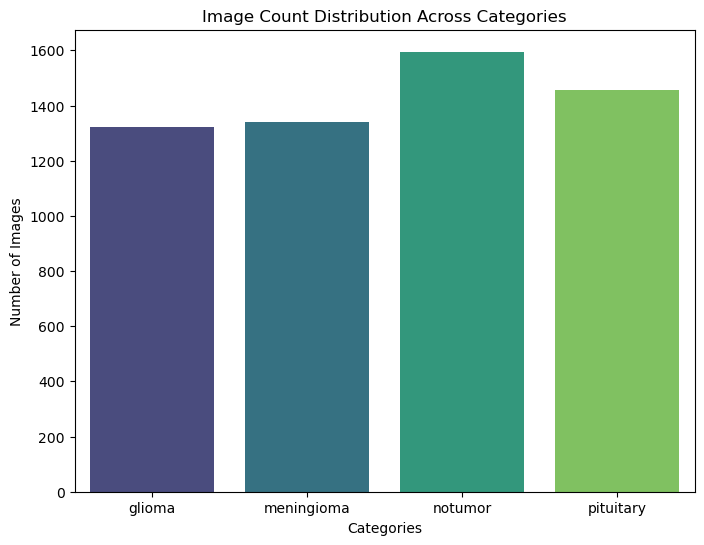

In [3]:
#getting class names from dataset
class_names = train_dataset.class_names  

#converting labels to integers
image_counts = Counter([int(tf.argmax(label).numpy()) for _, label in train_dataset.unbatch()])

#converting counts to list based on class indices
counts = [image_counts[i] for i in range(len(class_names))]

#bar chart
plt.figure(figsize=(8, 6))
sns.barplot(x=class_names, y=counts, palette='viridis')
plt.title("Image Count Distribution Across Categories")
plt.ylabel("Number of Images")
plt.xlabel("Categories")
plt.show()

#### Intensity Histograms 
- Examined pixel intensity distributions to understand brightness levels and detect anomalies.

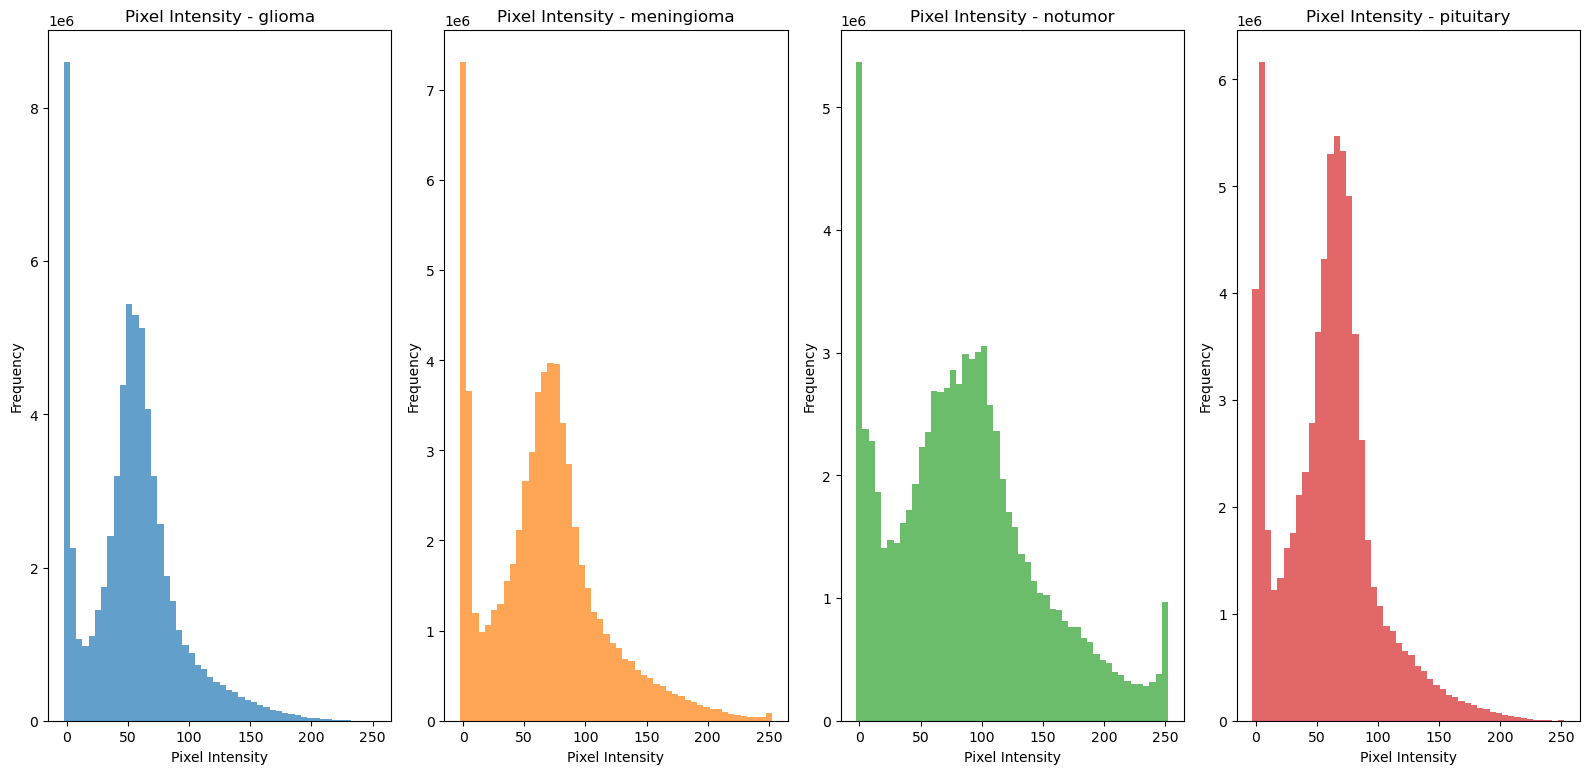

In [4]:
def plot_intensity_histograms(dataset, class_names):

    #initializing histograms for each class
    bins = np.linspace(0, 255, 51)  #defining 50 bins for pixel intensity (0-255)
    histograms = {class_name: np.zeros(len(bins) - 1) for class_name in class_names}

    #processing dataset in batches
    for image, label in dataset.unbatch():
        #converting label to scalar index
        class_index = tf.argmax(label).numpy() if len(label.shape) > 0 else label.numpy()
        class_name = class_names[class_index]

        #calculating histogram for current image
        pixels = image.numpy().flatten()
        hist, _ = np.histogram(pixels, bins=bins)
        histograms[class_name] += hist

    #plotting histograms
    plt.figure(figsize=(16, 8))
    for i, class_name in enumerate(class_names):
        plt.subplot(1, len(class_names), i + 1)
        plt.bar(bins[:-1], histograms[class_name], width=np.diff(bins), color=f'C{i}', alpha=0.7)
        plt.title(f"Pixel Intensity - {class_name}")
        plt.xlabel("Pixel Intensity")
        plt.ylabel("Frequency")
    plt.tight_layout()
    plt.show()

#calling function
plot_intensity_histograms(train_dataset, class_names)

#### Sample Visualization
- Displayed sample images from each category to visually confirm label correctness and check for variations in image quality.

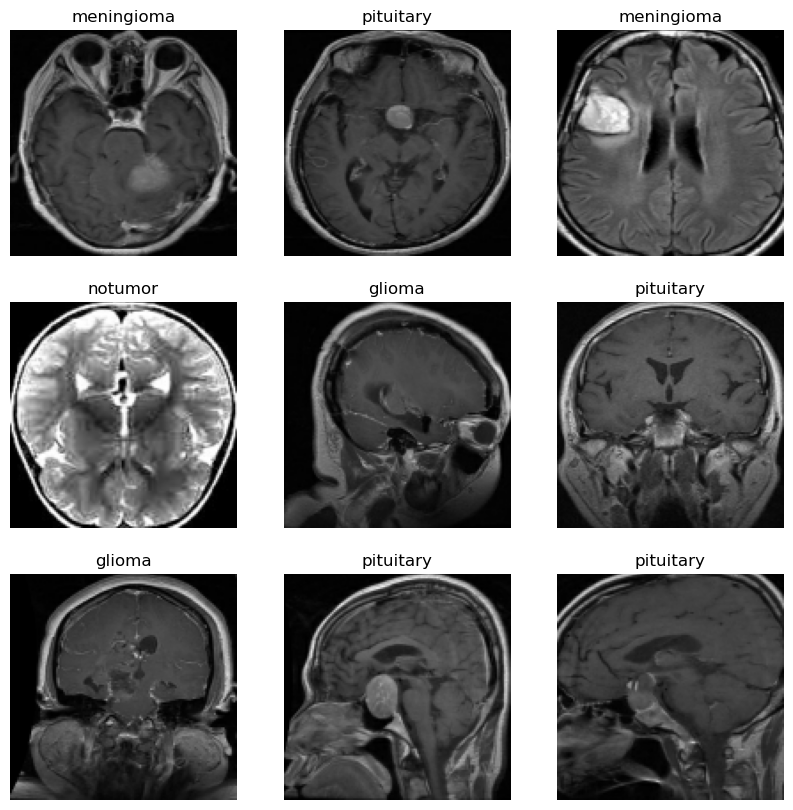

In [5]:
#visualizing a batch of images
plt.figure(figsize=(10, 10))
for images, labels in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.title(class_names[tf.argmax(labels[i]).numpy()])
        plt.axis("off")
plt.show()

### Normalization and Augmentation

In [6]:
def normalize(image, label):
    image = tf.cast(image, tf.float32) / 255.0  #normalizing to [0, 1]
    return image, label

#augmenting to help with generalization
data_augmentation = tf.keras.Sequential([
  tf.keras.layers.RandomFlip("horizontal"),
  tf.keras.layers.RandomRotation(0.1),
  tf.keras.layers.RandomZoom(0.1),
])

#applying normalization and augmentation
train_dataset = train_dataset.map(normalize, num_parallel_calls=AUTOTUNE)
train_dataset = train_dataset.map(lambda x, y: (data_augmentation(x, training=True), y))
train_dataset = train_dataset.prefetch(AUTOTUNE)

val_dataset = val_dataset.map(normalize, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)
test_dataset = test_dataset.map(normalize, num_parallel_calls=AUTOTUNE).prefetch(AUTOTUNE)

Instructions for updating:
Lambda fuctions will be no more assumed to be used in the statement where they are used, or at least in the same block. https://github.com/tensorflow/tensorflow/issues/56089


### CNN Model Design

In [7]:
#building CNN model
def build_cnn(input_shape=(128, 128, 3), num_classes=4):
    model = Sequential([
        Conv2D(32, (3, 3), activation='relu', input_shape=input_shape),
        MaxPooling2D((2, 2)),
        Conv2D(64, (3, 3), activation='relu'),
        Dropout(0.3),
        Conv2D(64, (3, 3), activation='relu'),
        MaxPooling2D((2, 2)),
        Flatten(),
        Dense(64, activation='relu'),
        Dense(num_classes, activation='softmax')
    ])
    return model

cnn_model = build_cnn()

#learning rate schedule
lr_schedule = tf.keras.optimizers.schedules.ExponentialDecay(
    initial_learning_rate=1e-3,
    decay_steps=10000,
    decay_rate=0.9)
optimizer = tf.keras.optimizers.Adam(learning_rate=lr_schedule)

#compiling model
cnn_model.compile(optimizer=optimizer, loss='categorical_crossentropy', metrics=['accuracy'])

#callbacks
callbacks = [
    tf.keras.callbacks.EarlyStopping(monitor='val_accuracy', patience=5, restore_best_weights=True),
    tf.keras.callbacks.ModelCheckpoint('best_model.h5', monitor='val_accuracy', save_best_only=True)
]

#### Iteration and Performance Improvements
Through multiple iterations, key enhancements included:

- Optimization of learning rate and batch size, which improved training stability.
- Data augmentation (rotations, flips) to enhance generalization.
- Class weighting to counter class imbalance, reducing overprediction of dominant classes like "no tumor." 

Despite these efforts, "meningioma" and "glioma" classification require further refinement.

### Model Training

In [8]:
#tracking performance over each epoch
history = cnn_model.fit(
    train_dataset,
    validation_data=val_dataset,
    epochs=50,
    callbacks=callbacks
)

Epoch 1/50
179/179 [==============================] - 120s 631ms/step - loss: 1.0763 - accuracy: 0.5061 - val_loss: 0.7093 - val_accuracy: 0.7227
Epoch 2/50
179/179 [==============================] - 127s 699ms/step - loss: 0.7638 - accuracy: 0.6941 - val_loss: 0.5522 - val_accuracy: 0.7656
Epoch 3/50
179/179 [==============================] - 127s 698ms/step - loss: 0.6399 - accuracy: 0.7464 - val_loss: 0.4829 - val_accuracy: 0.8398
Epoch 4/50
179/179 [==============================] - ETA: 0s - loss: 0.5949 - accuracy: 0.7734

2024-12-05 16:34:29.496008: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 3 of 41
2024-12-05 16:34:36.900670: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 4 of 41
2024-12-05 16:34:48.085762: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 6 of 41
2024-12-05 16:35:00.095734: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 8 of 41
2024-12-05 16:35:13.388111: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 11 of 41
2024-12-05 16:35:25.389598: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a while): 12 of 41
2024-12-05 16:35:27.491729: I tensorflow/core/kernels/data/shuffle_dataset_op.cc:392] Filling up shuffle buffer (this may take a

179/179 [==============================] - 545s 3s/step - loss: 0.5949 - accuracy: 0.7734 - val_loss: 0.4144 - val_accuracy: 0.8359
Epoch 5/50
179/179 [==============================] - 116s 639ms/step - loss: 0.5139 - accuracy: 0.8026 - val_loss: 1.0220 - val_accuracy: 0.6484
Epoch 6/50
179/179 [==============================] - 114s 622ms/step - loss: 0.4813 - accuracy: 0.8199 - val_loss: 0.8961 - val_accuracy: 0.7031
Epoch 7/50
179/179 [==============================] - 110s 603ms/step - loss: 0.4310 - accuracy: 0.8385 - val_loss: 0.4722 - val_accuracy: 0.8281
Epoch 8/50
179/179 [==============================] - 115s 632ms/step - loss: 0.4081 - accuracy: 0.8463 - val_loss: 0.3615 - val_accuracy: 0.8906
Epoch 9/50
179/179 [==============================] - 118s 646ms/step - loss: 0.3740 - accuracy: 0.8593 - val_loss: 0.4432 - val_accuracy: 0.8516
Epoch 10/50
179/179 [==============================] - 116s 638ms/step - loss: 0.3465 - accuracy: 0.8736 - val_loss: 0.2122 - val_accuracy

### Plotting Training History

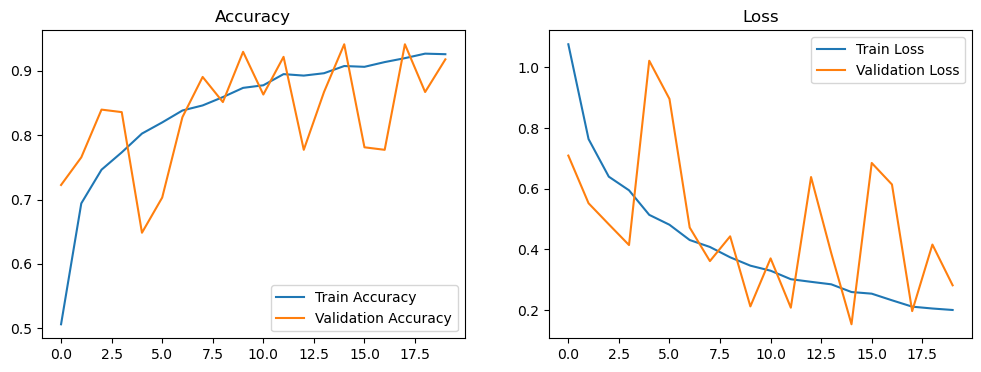

In [9]:
#plotting training history
def plot_history(history):
    plt.figure(figsize=(12, 4))
    plt.subplot(121)
    plt.plot(history.history['accuracy'], label='Train Accuracy')
    plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.subplot(122)
    plt.plot(history.history['loss'], label='Train Loss')
    plt.plot(history.history['val_loss'], label='Validation Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()
    
plot_history(history)


### Model Evaluation

33/33 [==============================] - 8s 87ms/step - loss: 0.5005 - accuracy: 0.8314
Test Loss: 0.5004677772521973
Test Accuracy: 0.8314393758773804
1/1 [==============================] - 0s 82ms/step

Classification Report:
              precision    recall  f1-score   support

      glioma       0.94      0.70      0.80       269
  meningioma       0.71      0.67      0.69       210
     notumor       0.85      0.97      0.91       353
   pituitary       0.83      0.95      0.89       224

    accuracy                           0.84      1056
   macro avg       0.83      0.82      0.82      1056
weighted avg       0.84      0.84      0.83      1056



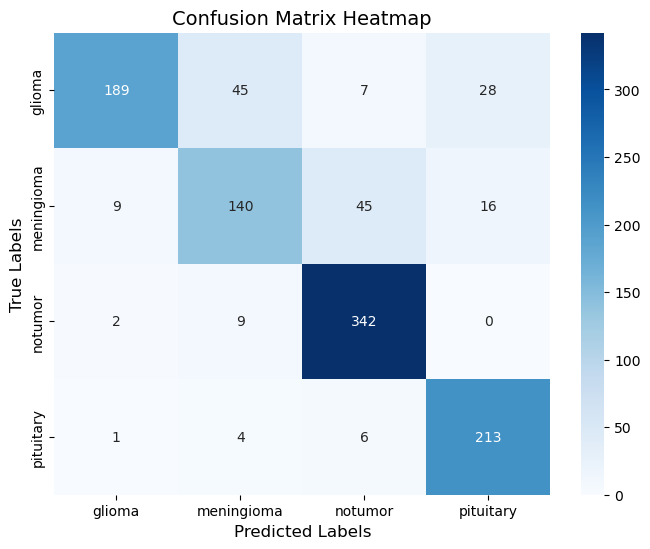

In [18]:
from sklearn.metrics import classification_report, confusion_matrix

#evaluating model on test set
test_loss, test_accuracy = cnn_model.evaluate(test_dataset)
print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {test_accuracy}")

#generating predictions and labels
y_true = []
y_pred = []
for images, labels in test_dataset:
    #adding true labels
    y_true.extend(labels.numpy())
    #adding predicted labels
    predictions = cnn_model.predict(images)
    y_pred.extend(tf.argmax(predictions, axis=1).numpy())

#converting one-hot encoded y_true to class indices
if len(y_true[0].shape) > 0:  #checking if one-hot encoded
    y_true = [np.argmax(label) for label in y_true]

#classification metrics
print("\nClassification Report:")
print(classification_report(y_true, y_pred, target_names=class_names))

#confusion matrix
cm = confusion_matrix(y_true, y_pred)

#plotting matrix as heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=class_names, yticklabels=class_names)

#labels and title
plt.xlabel('Predicted Labels', fontsize=12)
plt.ylabel('True Labels', fontsize=12)
plt.title('Confusion Matrix Heatmap', fontsize=14)

plt.show()

#saving model
cnn_model.save("brain_tumor_classifier_cnn.h5")

### Inference

In [11]:
#predicting on multiple images
def predict_images(model, img_paths):
    img_arrays = []
    for img_path in img_paths:
        img = tf.keras.utils.load_img(img_path, target_size=IMG_SIZE)
        img_array = tf.keras.utils.img_to_array(img) / 255.0
        img_arrays.append(img_array)
    
    batch = tf.stack(img_arrays)
    predictions = model.predict(batch)
    predicted_classes = [class_names[tf.argmax(pred)] for pred in predictions]
    confidences = [tf.reduce_max(pred).numpy() for pred in predictions]
    return predicted_classes, confidences

#example usage of predict_images on images picked at random from each category
model = tf.keras.models.load_model("brain_tumor_classifier_cnn.h5")
img_paths = ["cleaned/Testing/glioma/Te-gl_0205.jpg", 
             "cleaned/Testing/meningioma/Te-me_0174.jpg",
             "cleaned/Testing/notumor/Te-no_0233.jpg", 
             "cleaned/Testing/pituitary/Te-pi_0215.jpg"
            ]
predicted_classes, confidences = predict_images(model, img_paths)
for i, (cls, conf) in enumerate(zip(predicted_classes, confidences)):
    print(f"Image {i+1}: Predicted Class: {cls}, Confidence: {conf:.2f}")

1/1 [==============================] - 0s 73ms/step
Image 1: Predicted Class: glioma, Confidence: 0.84
Image 2: Predicted Class: meningioma, Confidence: 0.92
Image 3: Predicted Class: notumor, Confidence: 1.00
Image 4: Predicted Class: pituitary, Confidence: 0.98


### Results and Analysis

The CNN-based brain tumor classification model achieved a test accuracy of 83.14% and a test loss of 0.5005. These metrics suggest good overall performance in distinguishing between the four classes: glioma, meningioma, no tumor, and pituitary tumors. Detailed evaluation metrics and insights are presented below:

#### Classification Metrics
The following metrics were calculated for the test dataset:
- Precision: evaluates the fraction of correct positive predictions among all predicted positives.
- Recall: measures the fraction of correct positive predictions among actual positives.
- F1-score: a harmonic mean of precision and recall.

| Class | Precision | Recall | F1-score |
| :- | :-: | :-: | :-: |
| Glioma | 0.94 | 0.70 | 0.80 |
| Meningioma | 0.71 | 0.67 | 0.69 |
| No Tumor | 0.85 | 0.97 | 0.91 |
| Pituitary | 0.83 | 0.95 | 0.89 |

The overall weighted average F1-score was **0.83**, reflecting a well-balanced performance across all classes.

#### Confusion Matrix Analysis
"Glioma" was misclassified as "no tumor" and "pituitary" in some cases, suggesting overlaps in feature representations.
Meningioma had the lowest recall (67%), with several instances misclassified as "glioma" and "pituitary."
No tumor and pituitary had high recall (96% and 95%, respectively), reflecting the model's strong ability to identify these classes correctly.

#### Metric Justification
The choice of precision, recall, and F1-score was deliberate, given the class imbalance and clinical importance of reducing false positives (precision) and false negatives (recall). The F1-score was particularly insightful in balancing these two aspects.

### Discussion and Conclusion
The results demonstrate the effectiveness of the CNN model in classifying brain tumor types, achieving high accuracy and precision for most classes. However, certain limitations and areas for improvement were noted:

- Misclassification Issues: Overlaps in "glioma" and "meningioma" classifications suggest a need for additional feature extraction layers or enhanced preprocessing techniques.
- Class Imbalance: The dataset imbalance hindered optimal performance, particularly for minority classes. Employing advanced techniques like SMOTE or focal loss could mitigate this issue.
- Overfitting: The divergence between training and validation metrics post-20 epochs indicates overfitting. Techniques such as dropout, L2 regularization, or early stopping could be further fine-tuned.
#### Ways to Improve Results
- Data Collection: Expanding the dataset with more diverse and balanced samples would significantly improve generalization.
- Ensemble Learning: Combining multiple CNNs or integrating with other architectures like ResNet could enhance performance.
- Domain Knowledge Integration: Incorporating radiological or pathological expertise might refine feature engineering and labeling accuracy.
#### Future Work
Future iterations could explore transfer learning using pre-trained models and apply explainability techniques like Grad-CAM to visualize the model's decision-making process. This will provide valuable insights into the regions of interest contributing to each classification.

In conclusion, the model demonstrates promising capabilities in brain tumor classification, with room for targeted improvements to achieve clinical-grade reliability.